In [11]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost shap category_encoders imbalanced-learn

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

import shap
import category_encoders as ce

Matplotlib is building the font cache; this may take a moment.
/opt/homebrew/Caskroom/miniforge/base/envs/credit/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
df = pd.read_csv("Downloads/small_synthetic_credit_risk_dataset.csv")
df.head()

,customer_id,age,gender,marital_status,dependents,education_level,employment_status,annual_income,loan_amount,loan_term_months,...,num_credit_cards,credit_utilization,previous_defaults,mortgage,car_loan,personal_loan,late_payments,savings_account_balance,checking_account_balance,default
0,33554,20,Female,Married,2,High School,Employed,54544.334182,20887.837701,24,...,2,0.54,0,0,0,0,1,27054.617998,0.000000,0
1,9428,37,Male,Single,3,High School,Employed,79709.318295,17344.220049,12,...,3,0.91,0,1,0,0,1,16933.945011,4718.133387,0
2,200,37,Female,Married,4,Bachelor,Self-employed,55929.359396,17662.758814,60,...,4,0.10,0,0,1,0,0,0.000000,4500.404865,1
3,12448,32,Female,Single,2,Bachelor,Employed,74837.829176,23122.397672,48,...,2,0.11,0,1,0,0,2,1531.224601,3083.324845,0
4,39490,29,Male,Single,5,High School,Employed,45124.262645,22263.588030,36,...,2,0.42,0,1,0,1,0,23203.116092,7244.337303,0


In [17]:
print(df.isnull().sum())

customer_id                 0
age                         0
gender                      0
marital_status              0
dependents                  0
education_level             0
employment_status           0
annual_income               0
loan_amount                 0
loan_term_months            0
credit_score                0
num_credit_cards            0
credit_utilization          0
previous_defaults           0
mortgage                    0
car_loan                    0
personal_loan               0
late_payments               0
savings_account_balance     0
checking_account_balance    0
default                     0
dtype: int64


In [18]:
print(df['default'].value_counts(normalize=True))

default
1    0.5242
0    0.4758
Name: proportion, dtype: float64


In [19]:
print(df.describe())

        customer_id          age   dependents  annual_income   loan_amount  \
count   5000.000000  5000.000000  5000.000000    5000.000000   5000.000000   
mean   25098.232600    45.955800     2.519200   59900.089202  15189.278770   
std    14310.590082    16.688605     1.715057   19726.971218   4940.056728   
min        5.000000    18.000000     0.000000   10000.000000   1000.000000   
25%    12910.750000    31.750000     1.000000   46838.421029  11809.196904   
50%    25300.500000    46.000000     3.000000   59833.421042  15181.931162   
75%    37358.250000    61.000000     4.000000   73236.825643  18519.859225   
max    49989.000000    74.000000     5.000000  129411.073072  32567.222473   

       loan_term_months  credit_score  num_credit_cards  credit_utilization  \
count       5000.000000    5000.00000       5000.000000         5000.000000   
mean          37.876800     574.52360          3.008800            0.508286   
std           14.322913     158.92313          1.742909     

In [20]:
# Monthly income
monthly_income = df['annual_income'] / 12

# Approximate monthly debt
monthly_debt = (
    (df['mortgage'] + df['car_loan'] + df['personal_loan']) / df['loan_term_months']
) + 1e-9

# Debt to Income ratio
df['dti'] = monthly_debt / (monthly_income + 1e-9)

# Loan to Income ratio
df['loan_to_income'] = df['loan_amount'] / (df['annual_income'] + 1e-9)

# Age bucket
df['age_bucket'] = pd.cut(df['age'], bins=[17,25,35,45,55,65,100], labels=False)

df.head()


,customer_id,age,gender,marital_status,dependents,education_level,employment_status,annual_income,loan_amount,loan_term_months,...,mortgage,car_loan,personal_loan,late_payments,savings_account_balance,checking_account_balance,default,dti,loan_to_income,age_bucket
0,33554,20,Female,Married,2,High School,Employed,54544.334182,20887.837701,24,...,0,0,0,1,27054.617998,0.000000,0,2.200045e-13,0.382952,0
1,9428,37,Male,Single,3,High School,Employed,79709.318295,17344.220049,12,...,1,0,0,1,16933.945011,4718.133387,0,1.254558e-05,0.217593,2
2,200,37,Female,Married,4,Bachelor,Self-employed,55929.359396,17662.758814,60,...,0,1,0,0,0.000000,4500.404865,1,3.575940e-06,0.315805,2
3,12448,32,Female,Single,2,Bachelor,Employed,74837.829176,23122.397672,48,...,1,0,0,2,1531.224601,3083.324845,0,3.340557e-06,0.308967,1
4,39490,29,Male,Single,5,High School,Employed,45124.262645,22263.588030,36,...,1,0,1,0,23203.116092,7244.337303,0,1.477402e-05,0.493384,1


In [27]:
import category_encoders as ce

cat_cols = ['gender', 'marital_status', 'education_level', 'employment_status']

encoder = ce.TargetEncoder(cols=cat_cols)
df[cat_cols] = encoder.fit_transform(df[cat_cols], df['default'])

print("=== Step 6: Categorical variables after target encoding ===")
print(df[cat_cols].head())

=== Step 6: Categorical variables after target encoding ===
     gender  marital_status  education_level  employment_status
0  0.527789        0.543497         0.531568           0.513568
1  0.522028        0.511031         0.531568           0.513568
2  0.527789        0.543497         0.519819           0.553785
3  0.527789        0.511031         0.519819           0.513568
4  0.522028        0.511031         0.531568           0.513568


In [28]:
X = df.drop(columns=['customer_id', 'default'])
y = df['default']

print("=== Step 7: Features and target prepared ===")
print("Features shape:", X.shape)
print("Target distribution:")
print(y.value_counts(normalize=True))

=== Step 7: Features and target prepared ===
Features shape: (5000, 22)
Target distribution:
default
1    0.5242
0    0.4758
Name: proportion, dtype: float64


In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("=== Step 8: Train-Test Split ===")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train distribution:")
print(y_train.value_counts(normalize=True))
print("y_test distribution:")
print(y_test.value_counts(normalize=True))


=== Step 8: Train-Test Split ===
X_train shape: (4000, 22)
X_test shape: (1000, 22)
y_train distribution:
default
1    0.52425
0    0.47575
Name: proportion, dtype: float64
y_test distribution:
default
1    0.524
0    0.476
Name: proportion, dtype: float64


In [30]:
from sklearn.preprocessing import StandardScaler
import numpy as np

num_cols = X_train.select_dtypes(include=np.number).columns.tolist()

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

print("=== Step 9: Numeric features scaled ===")
print("Scaled features preview (X_train):")
print(X_train[num_cols].head())


=== Step 9: Numeric features scaled ===
Scaled features preview (X_train):
           age    gender  marital_status  dependents  education_level  \
1224 -0.105258 -0.499157        1.072844   -1.460736        -0.582331   
3501  0.904696  0.809598       -0.732768   -0.878015        -1.343964   
830   1.023515 -3.808020       -0.732768   -1.460736        -1.343964   
1076 -1.174622  0.809598        1.072844    0.870148         0.978238   
3527  1.439378 -0.499157       -1.292698   -0.295294         0.978238   

      employment_status  annual_income  loan_amount  loan_term_months  \
1224          -0.612335       1.012103    -1.080891         -0.129198   
3501          -0.498904       1.607315    -1.093644          1.548701   
830           -0.498904       1.683053    -0.044090          1.548701   
1076          -0.612335      -1.835539     0.117143          0.709752   
3527          -0.612335      -0.018177     0.616545          0.709752   

      credit_score  ...  previous_defaults  mor

In [32]:
xgb = XGBClassifier(eval_metric='logloss')  # remove use_label_encoder param
xgb.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [34]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# XGBoost without deprecated parameter
xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(X_train, y_train)

print("=== Step 10: Models trained ===")

=== Step 10: Models trained ===


Logistic Regression ROC-AUC: 0.8685
XGBoost ROC-AUC: 0.8399

=== Confusion Matrix for XGBoost ===


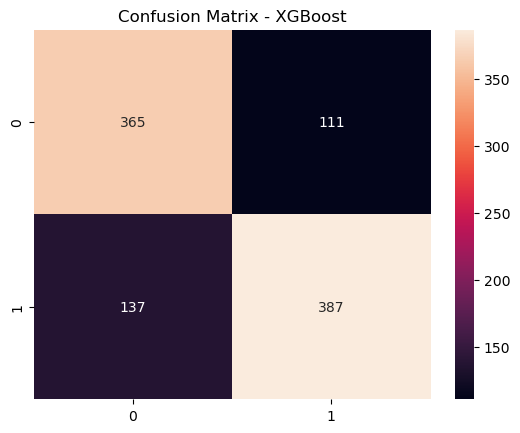

In [35]:
from sklearn.metrics import roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

for model, name in zip([lr, xgb], ['Logistic Regression', 'XGBoost']):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"{name} ROC-AUC: {auc:.4f}")

print("\n=== Confusion Matrix for XGBoost ===")
y_pred = xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix - XGBoost")
plt.show()

=== Step 12: SHAP summary plot ===


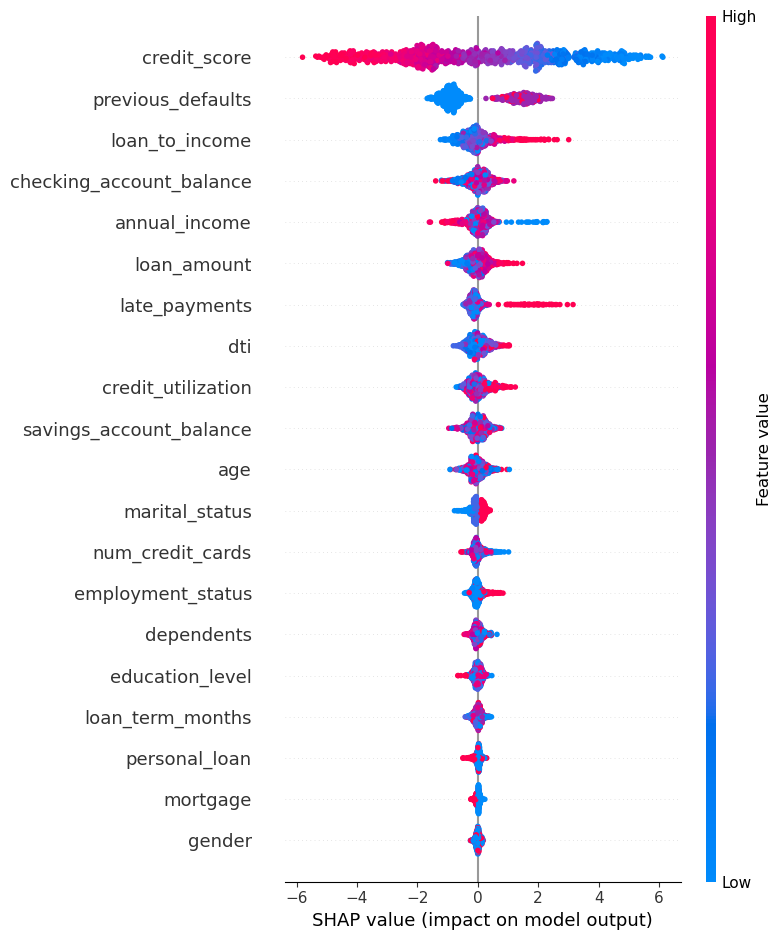

In [36]:
import shap

explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

print("=== Step 12: SHAP summary plot ===")
shap.summary_plot(shap_values, X_test)